In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from platypus import NSGAII, Problem, Real
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:

df = pd.read_csv("feature25_with_loss_new.csv")
data = df[['temperature', 'material', 'wave_label','frequency','max_flux','core_loss']]
data

,temperature,material,wave_label,frequency,max_flux,core_loss
0,25,0,2,50030,0.028849,1997.955250
1,25,0,2,50020,0.031419,2427.749830
2,25,0,2,50020,0.035535,3332.725760
3,25,0,2,50020,0.040015,4502.908007
4,25,0,2,50030,0.045028,6063.023248
...,...,...,...,...,...,...
12395,90,3,1,199190,0.034867,20604.900210
12396,90,3,1,199190,0.038341,26504.284280
12397,90,3,1,199190,0.048877,46232.491530
12398,90,3,1,199190,0.054889,61458.085900


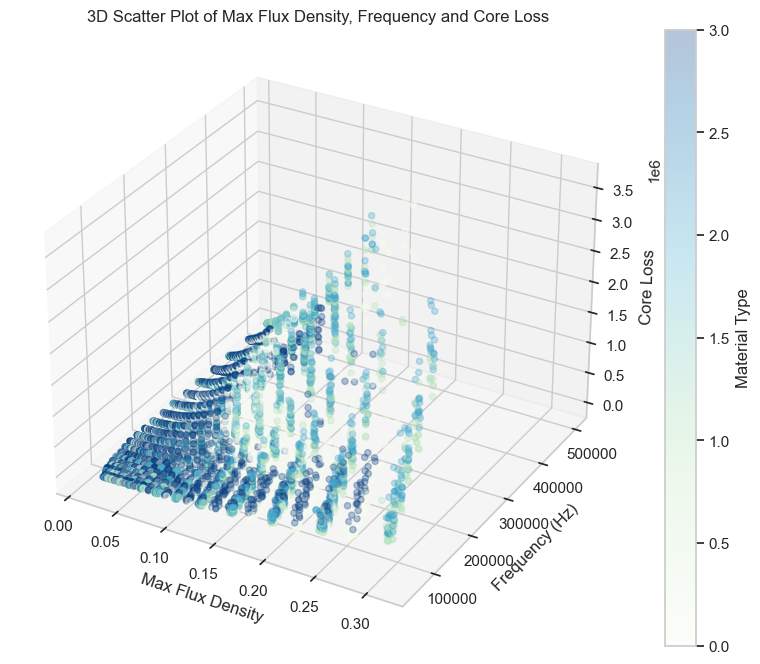

In [37]:
# 设置 Seaborn 绘图风格
sns.set_theme(style="whitegrid")
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', alpha=0.9)
# scatter = ax.scatter(data["max_flux"], data["frequency"], data["core_loss"], c=data["material"])
scatter = ax.scatter(data["max_flux"], data["frequency"], data["core_loss"], 
                    c=data["material"], cmap='GnBu',  # 使用 'jet' 颜色映射，或选择其他喜欢的颜色映射
                    alpha=0.3)  # 设置不透明度为 0.7，可以根据需要调整

ax.set_xlabel("Max Flux Density")
ax.set_ylabel("Frequency (Hz)")
ax.set_zlabel("Core Loss")
plt.title("3D Scatter Plot of Max Flux Density, Frequency and Core Loss")
plt.colorbar(scatter, label="Material Type")
plt.show()

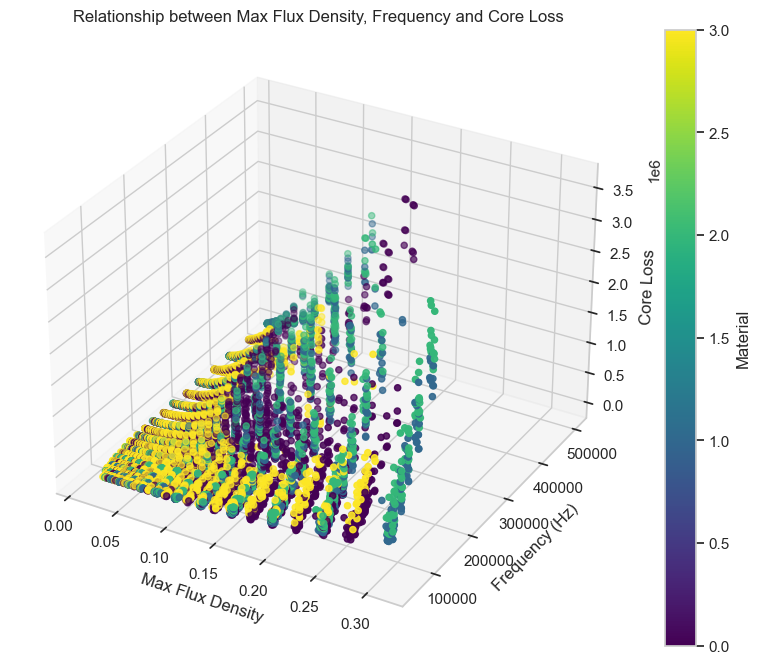

In [3]:
# 创建三维散点图

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图，颜色根据材料区分
scatter = ax.scatter(data["max_flux"], data["frequency"], data["core_loss"], c=data["material"], cmap='viridis')

# 设置坐标轴标签和标题
ax.set_xlabel("Max Flux Density")
ax.set_ylabel("Frequency (Hz)")
ax.set_zlabel("Core Loss")
plt.title("Relationship between Max Flux Density, Frequency and Core Loss")

# 添加颜色条
plt.colorbar(scatter, label="Material")

# 显示图表
plt.show()

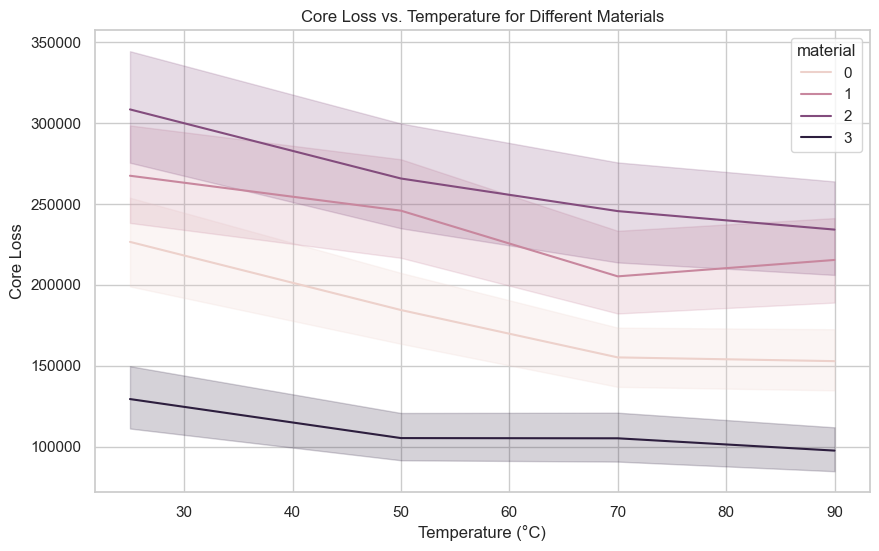

In [15]:
# 1. 温度与铁损的关系 (不同材料)
plt.figure(figsize=(10, 6))
sns.lineplot(x="temperature", y="core_loss", hue="material", data=data)
plt.xlabel("Temperature (°C)")
plt.ylabel("Core Loss")
plt.title("Core Loss vs. Temperature for Different Materials")
plt.show()

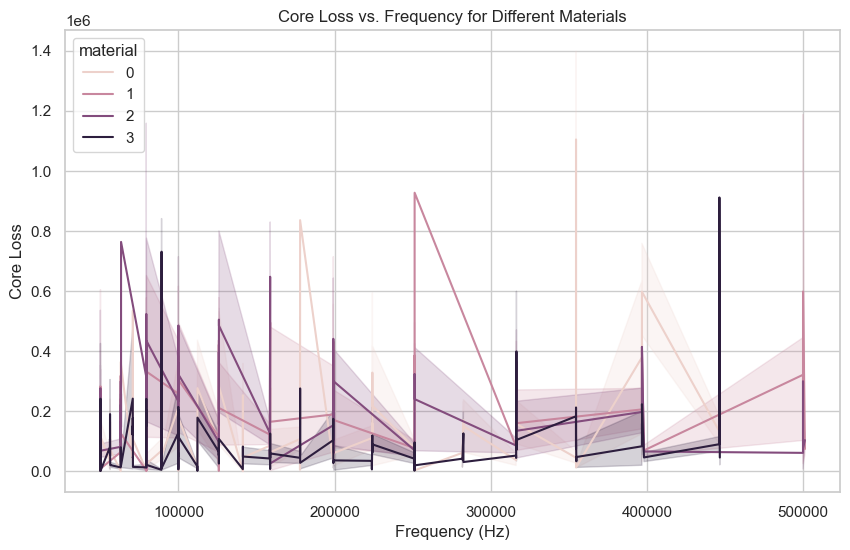

In [16]:
# 2. 频率与铁损的关系 (不同材料)
plt.figure(figsize=(10, 6))
sns.lineplot(x="frequency", y="core_loss", hue="material", data=data)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Core Loss")
plt.title("Core Loss vs. Frequency for Different Materials")
plt.show()

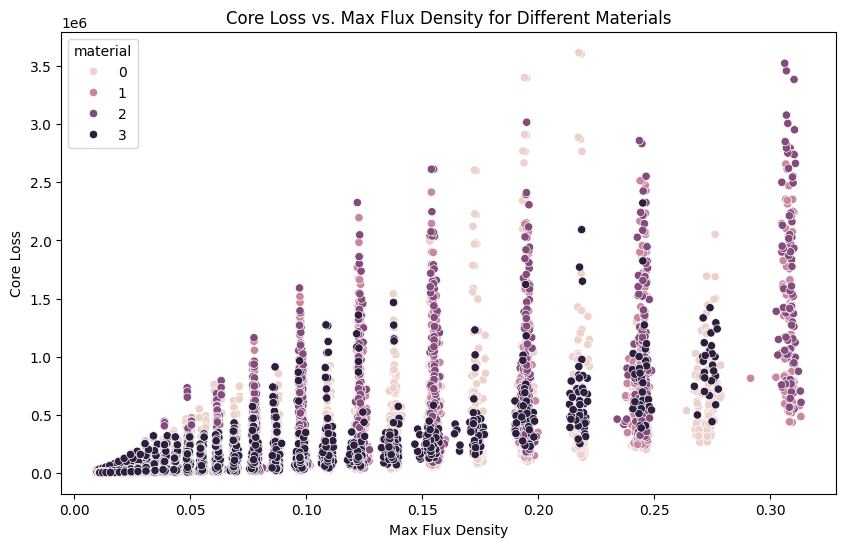

In [6]:
# 3. 最大磁通密度与铁损的关系 (不同材料)
plt.figure(figsize=(10, 6))
sns.scatterplot(x="max_flux", y="core_loss", hue="material", data=data)
plt.xlabel("Max Flux Density")
plt.ylabel("Core Loss")
plt.title("Core Loss vs. Max Flux Density for Different Materials")
plt.show()

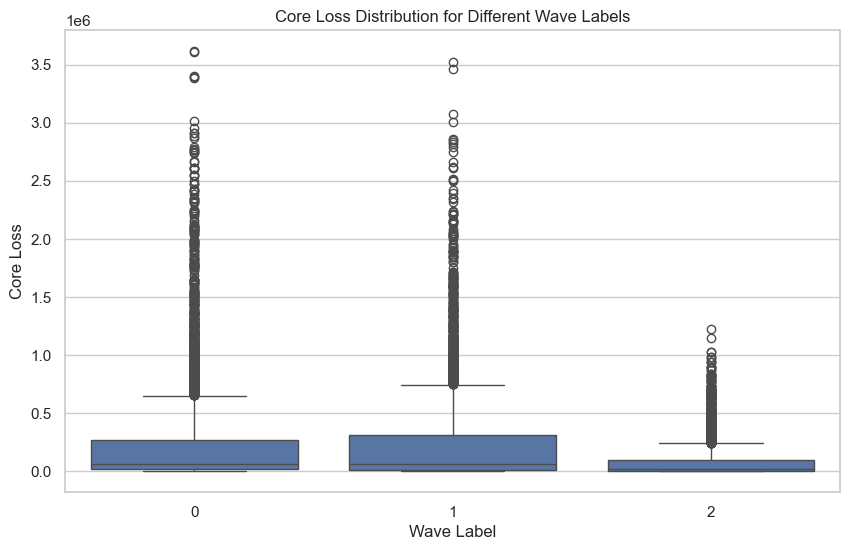

In [18]:
# 4. 不同波形标签下铁损的分布 (箱线图)
plt.figure(figsize=(10, 6))
sns.boxplot(x="wave_label", y="core_loss", data=data)
plt.xlabel("Wave Label")
plt.ylabel("Core Loss")
plt.title("Core Loss Distribution for Different Wave Labels")
plt.show()

In [12]:
Q1 = df['core_loss'].quantile(0.25)
Q3 = df['core_loss'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常值的范围
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 去除异常值
df_cleaned = data[(data['core_loss'] >= lower_bound) & (data['core_loss'] <= upper_bound)]

# 打印清理后数据的形状
print(f'清理后数据量: {df_cleaned.shape}')

清理后数据量: (10933, 6)


In [15]:

# Load dataset

# Features and target
X = df_cleaned.iloc[:, :-1].values
y = df_cleaned.iloc[:, -1].values

# Data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

# Further split the training set into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
# X_val = torch.tensor(X_val, dtype=torch.float32)  # Validation set
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
# y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)  # Validation set
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.nn.Softplus()( self.fc4(x)) + 100
        return x
def custom_loss(output, target):
    mse_loss = torch.mean((output - target) ** 2)
    penalty_lower = torch.mean((torch.relu(500 - output)) ** 2)
    penalty_upper = torch.mean((torch.relu(output - 600000)) ** 2)
    return mse_loss + 10 * penalty_lower + 100 * penalty_upper  # 通过调整100的权重来控制惩罚力度

Epoch [1/10000], Training Loss: 20729774080.0000, Validation Loss: 21663899648.0000
Epoch [201/10000], Training Loss: 19970379776.0000, Validation Loss: 20846430208.0000
Epoch [401/10000], Training Loss: 10299796480.0000, Validation Loss: 10557182976.0000
Epoch [601/10000], Training Loss: 5886040576.0000, Validation Loss: 5861976064.0000
Epoch [801/10000], Training Loss: 4537790976.0000, Validation Loss: 4516869632.0000
Epoch [1001/10000], Training Loss: 3962021888.0000, Validation Loss: 3951891712.0000
Epoch [1201/10000], Training Loss: 3700883456.0000, Validation Loss: 3694851328.0000
Epoch [1401/10000], Training Loss: 3561439744.0000, Validation Loss: 3546989824.0000
Epoch [1601/10000], Training Loss: 3410717952.0000, Validation Loss: 3388151296.0000
Epoch [1801/10000], Training Loss: 3183612416.0000, Validation Loss: 3154488832.0000
Epoch [2001/10000], Training Loss: 2857787392.0000, Validation Loss: 2821269504.0000
Epoch [2201/10000], Training Loss: 2379577088.0000, Validation Los

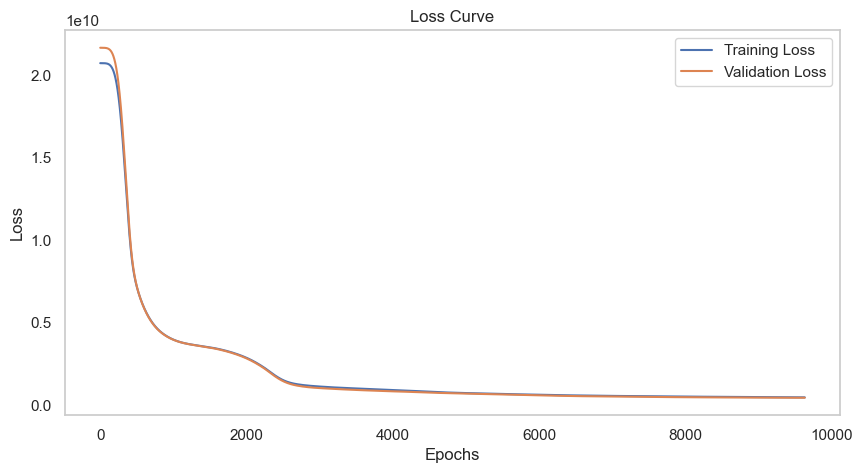

Mean Squared Error (MSE): 437305408.0
R^2 Score: 0.9682175517082214


In [11]:

# Instantiate the model
input_size = X_scaled.shape[1]
model = NeuralNet(input_size)

# Define loss function and optimizer
criterion = custom_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
val_losses = []
# Early stopping parameters
patience = 50
best_loss = np.inf
patience_counter = 0

# Train the model
num_epochs = 10_000
for epoch in range(num_epochs):
    # Forward pass
    model.train()  # Set to training mode
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_test)  # Use validation set
        val_loss = criterion(val_outputs, y_test)  # Use validation targets
    # Record losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    # Check for best loss and early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        
        if patience_counter >= patience:
            print('Early stopping triggered!')
            break  # Stop training
    if epoch % 200 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(None)
plt.show()

# Test the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

In [12]:
torch.save(model.state_dict(),'p5_model.pt')

In [16]:
m = NeuralNet(X_scaled.shape[1])
m.load_state_dict(torch.load('p5_model.pt', weights_only=True))
m.eval()

NeuralNet(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

tensor([[ 19857.0645],
        [ 18674.9512],
        [ 14316.0400],
        ...,
        [320256.6875],
        [ 37510.7109],
        [ 64726.9805]], grad_fn=<AddBackward0>)

In [35]:
def predict_core_loss(params):
    with torch.no_grad():
        input_tensor = torch.tensor(params, dtype=torch.float32).unsqueeze(0)
        return model(input_tensor).item()

def objective_function(params, w1, w2):
# data = df[['temperature', 'material', 'wave_label','frequency','max_flux','core_loss']]
    # Round categorical variables
    params_rounded = params.copy().reshape(-1,1)
    x_scaled = scaler.fit_transform(params_rounded)
    core_loss = predict_core_loss(x_scaled)
    
    frequency = params[3]
    peak_flux_density = params[4]

    
    power_transfer = frequency * peak_flux_density
    
    
    return w1 * core_loss - w2 * power_transfer


In [ ]:
import numpy as np
import torch
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

# 假设 model 是之前训练好的神经网络模型
# 确保 model 已经定义并加载了权重

class MagneticCoreProblem(Problem):
    def __init__(self):
        super().__init__(n_var=5,  # 5个变量
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0, 0, 0, 5000, 0.0]),  # 下限
                         xu=np.array([100, 3, 2, 500_000, 0.3]))  # 上限

    def _evaluate(self, X, out, *args, **kwargs):
        # 将 numpy 数组转换为 PyTorch 张量
        X_tensor = torch.FloatTensor(X)
        
        # 计算磁芯损耗
        with torch.no_grad():
            core_loss = model(X_tensor).numpy()
        
        # 计算传输磁能 (X[:, 3]是频率，X[:, 4]是磁通密度峰值)
        magnetic_energy = X[:, 3] * X[:, 4]
        
        out["F"] = np.column_stack([core_loss, -magnetic_energy])

problem = MagneticCoreProblem()

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               verbose=True)

# 分析结果
optimal_solutions = res.X
optimal_objectives = res.F

# 打印部分结果
print("最优解的数量:", len(optimal_solutions))
print("\n部分最优解:")
for i in range(min(5, len(optimal_solutions))):
    print(f"解 {i+1}:")
    print("  参数 (温度, 材料, 波形, 频率, 磁通密度峰值):", optimal_solutions[i])
    print("  目标值 (磁芯损耗, -传输磁能):", optimal_objectives[i])
    print()

# 可视化帕累托前沿
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(optimal_objectives[:, 0], -optimal_objectives[:, 1], c='blue', s=30)
plt.xlabel('loss')
plt.ylabel('b')
plt.title('pa')
plt.grid(True)
plt.show()

In [19]:
import torch
import numpy as np
from scipy.optimize import differential_evolution

# 加载标准化模型和训练好的神经网络模型
scaler = StandardScaler()
m.eval()  # 确保模型在评估模式下

# 优化目标函数，最小化磁芯损耗和最大化传输磁能
def objective_function(params):
    temperature, material, wave_label, frequency, max_flux = params
    
    X_input = np.array([[temperature, material, wave_label, frequency, max_flux]])
    X_input_scaled = scaler.fit_transform(X_input)
    X_input_tensor = torch.tensor(X_input_scaled, dtype=torch.float32)
    with torch.no_grad():
        core_loss = m(X_input_tensor).item()
    transmission_energy = frequency * max_flux
    
    return core_loss - transmission_energy

bounds = [
    (25, 90),  # 温度范围
    (0, 3),    # 材料索引范围
    (1, 2),    # 波形标签范围
    (50000, 200000),  # 频率范围
    (0.01, 0.3)  # 磁通密度峰值范围
]

# 使用遗传算法进行全局优化
result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=1000)

optimal_temperature, optimal_material, optimal_wave_label, optimal_frequency, optimal_max_flux = result.x
optimal_core_loss = m(torch.tensor(scaler.transform([[optimal_temperature, optimal_material, optimal_wave_label, optimal_frequency, optimal_max_flux]]), dtype=torch.float32)).item()
optimal_transmission_energy = optimal_frequency * optimal_max_flux



In [8]:
import numpy as np
np.max(df['max_flux'])

np.float64(0.313284469)

In [21]:

print(f"最优温度: {np.floor( optimal_temperature )}")
print(f"最优材料: {round( optimal_material )}")
print(f"最优波形: {round( optimal_wave_label )}")
print(f"最优频率: {optimal_frequency:.2f}")
print(f"最优磁通密度: {optimal_max_flux}")
print(f"最小磁芯损耗: {optimal_core_loss:.2f}")
print(f"最大传输磁能: {optimal_transmission_energy:.2f}")

最优温度: 55.0
最优材料: 2
最优波形: 2
最优频率: 200000.00
最优磁通密度: 0.3
最小磁芯损耗: 61198.95
最大传输磁能: 60000.00


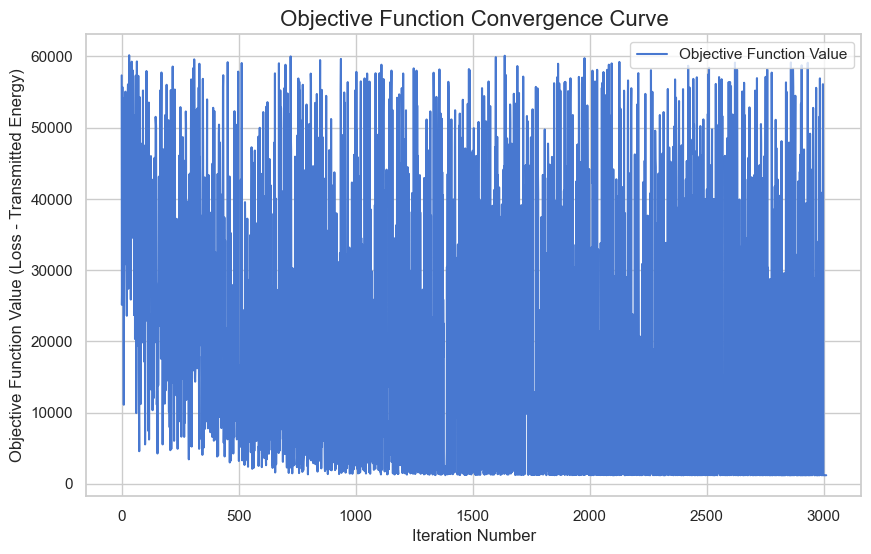

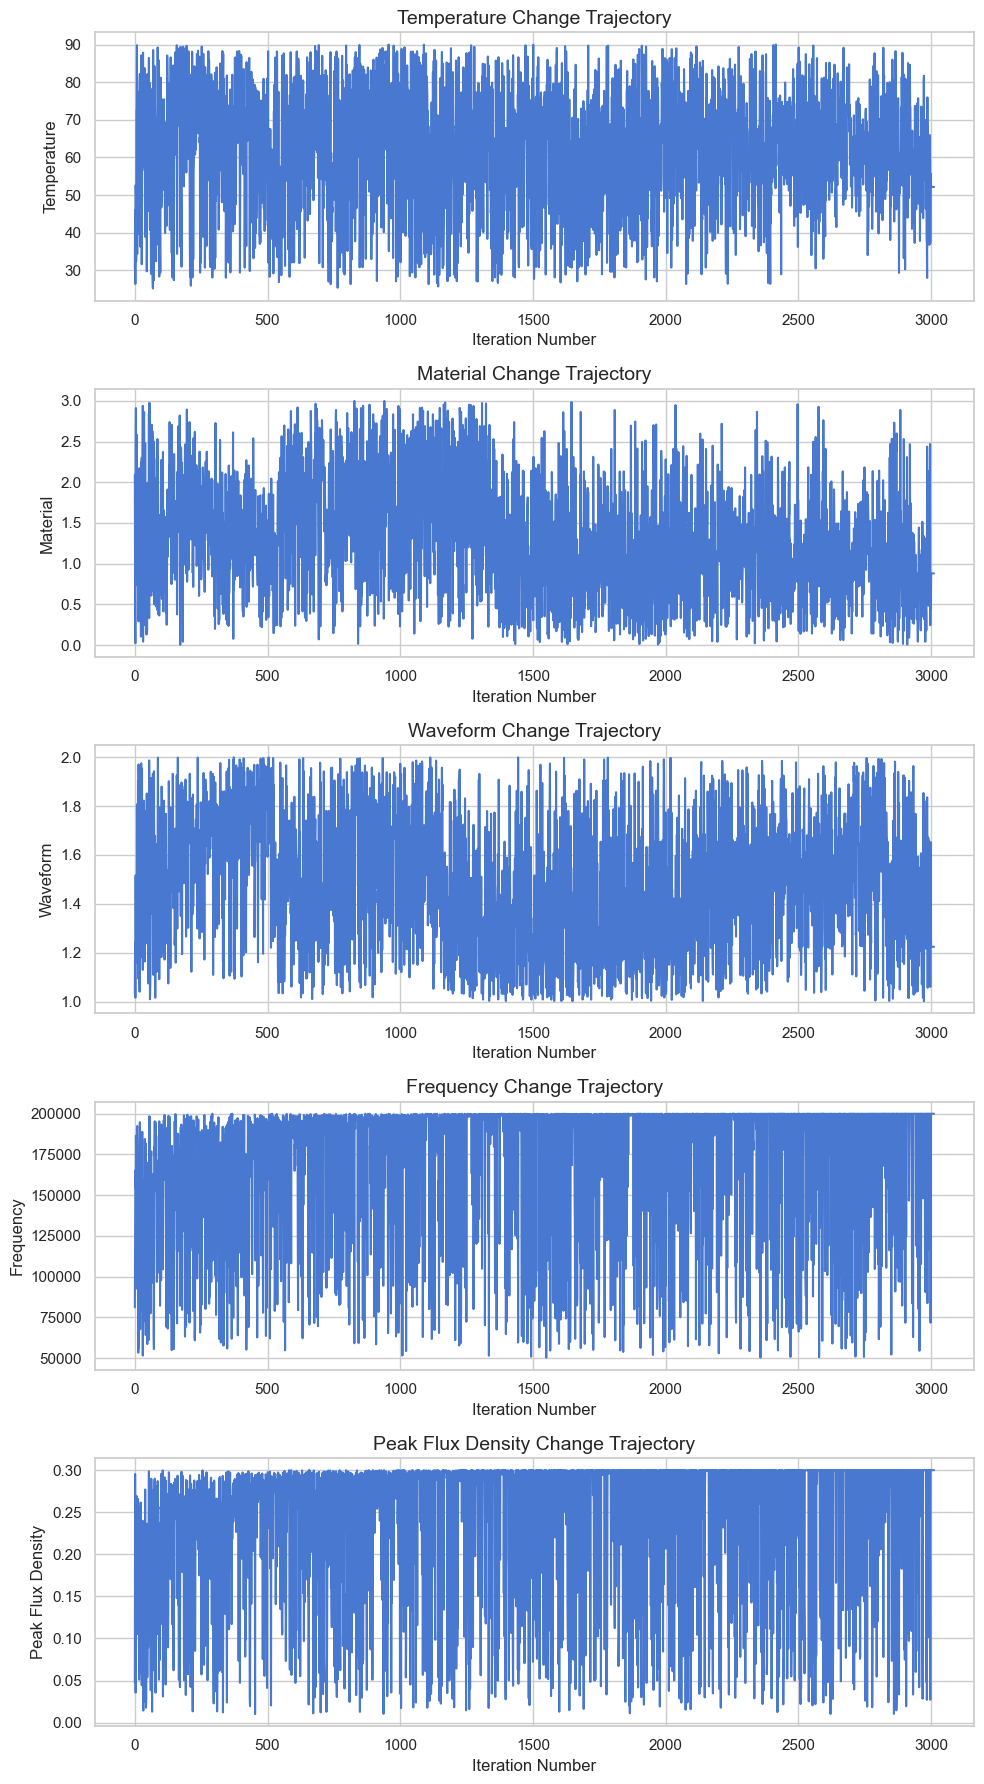

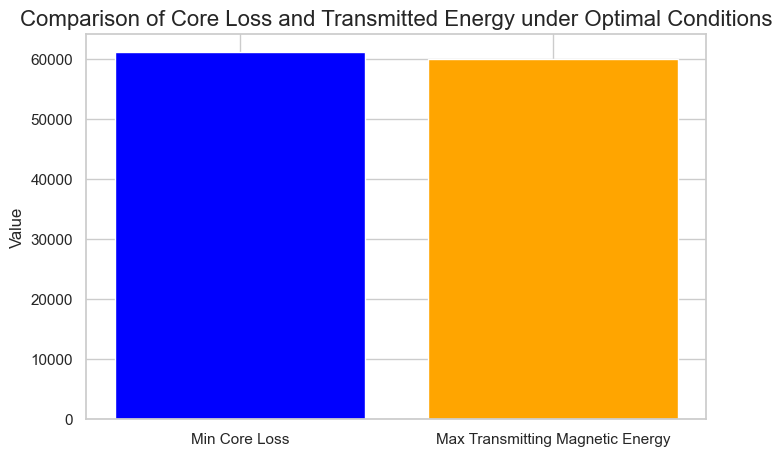

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.optimize import differential_evolution
from sklearn.preprocessing import StandardScaler

model = m
# Initialize model, data, and optimization settings
scaler = StandardScaler()
model.eval()  # Ensure the model is in evaluation mode
objective_history = []  # Record the objective function value for each iteration
param_history = []  # Record the parameter changes for each iteration

# Objective function (record each iteration)
def objective_function(params):
    temperature, material, wave_label, frequency, max_flux = params
    X_input = np.array([[temperature, material, wave_label, frequency, max_flux]])
    X_input_scaled = scaler.fit_transform(X_input)
    X_input_tensor = torch.tensor(X_input_scaled, dtype=torch.float32)
    with torch.no_grad():
        core_loss = model(X_input_tensor).item()
    transmission_energy = frequency * max_flux
    objective_value = core_loss - transmission_energy
    objective_history.append(objective_value)
    param_history.append(params)
    return objective_value

# Optimization settings and execution
bounds = [(25, 90), (0, 3), (1, 2), (50000, 200000), (0.01, 0.3)]
result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=1000)

# Extract the optimal solution
optimal_params = result.x
optimal_core_loss = model(torch.tensor(scaler.transform([optimal_params]), dtype=torch.float32)).item()
optimal_transmission_energy = optimal_params[3] * optimal_params[4]

# Visualization 1: Convergence curve
plt.figure(figsize=(10, 6))
plt.plot(objective_history, label="Objective Function Value", color="b")
plt.title("Objective Function Convergence Curve", fontsize=16)
plt.xlabel("Iteration Number", fontsize=12)
plt.ylabel("Objective Function Value (Loss - Transmitted Energy)", fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig("convergence_curve.png", dpi=300)

# Visualization 2: Parameter change trajectory
param_history = np.array(param_history)
fig, axs = plt.subplots(5, 1, figsize=(10, 18))
params_names = ["Temperature", "Material", "Waveform", "Frequency", "Peak Flux Density"]
for i in range(5):
    axs[i].plot(param_history[:, i], label=f"{params_names[i]}")
    axs[i].set_title(f"{params_names[i]} Change Trajectory", fontsize=14)
    axs[i].set_xlabel("Iteration Number", fontsize=12)
    axs[i].set_ylabel(f"{params_names[i]}", fontsize=12)
    axs[i].grid(True)
plt.tight_layout()
plt.savefig("parameter_trajectories.png", dpi=300)

# Visualization 3: Comparison of core loss and transmitted energy under optimal conditions
plt.figure(figsize=(8, 5))
bar_labels = ['Min Core Loss', 'Max Transmitting Magnetic Energy']
bar_values = [optimal_core_loss, optimal_transmission_energy]
plt.bar(bar_labels, bar_values, color=['blue', 'orange'])
plt.title("Comparison of Core Loss and Transmitted Energy under Optimal Conditions", fontsize=16)
plt.ylabel("Value", fontsize=12)
plt.savefig("core_loss_vs_energy.png", dpi=300)

plt.show()
